## The exploration - exploitation dilemma
### September 5, 2019

### The Reinfocerment Learning Problem
<img src="imgs/rl_diagram.png" alt="Drawing" style="margin-left:auto; margin-right:auto; width: 650px;"/>

* In RL the policy (controller) is supposed to be applied to an **stochastic environment** $\rightarrow$ **Given an action there is not complete certainty of landing in a determined state**

**Example:** throw a ball from of a hill which is affected by winds.

<img src="imgs/hill.jpg" alt="Drawing" style="margin-left:auto; margin-right:auto; width: 450px;"/>


<center>Can you, with complete certainty, determine where the ball will land?</center>

* The interaction with the environment can either end in a finite ammount of steps $T$ or go forever.

## The $k$-Armed Bandit Problem
<img src="imgs/slot_machine.jpg" alt="Drawing" style="margin-left:auto; margin-right:auto; width: 450px;"/>

* Imagine that you have k-levers in the slot machine.
* Using a different lever can result in a different ammount of reward.
* The reward received for each lever is not deterministic.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For reproducibitliy
np.random.seed(0)
## Create the Reward distributions
levers = np.arange(1, 11)
mean_rewards = [np.random.normal(0, 1) for _ in levers]
reward_distributions = [np.random.normal(mean_reward, 1, size = 100) for mean_reward in mean_rewards]

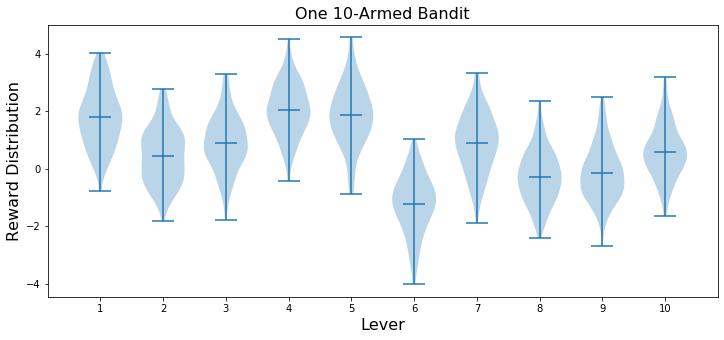

In [2]:
 ## Create the figure and assing the size
plt.figure(figsize = (12, 5))
## Plot the reward distribution for each lever
plt.violinplot(reward_distributions, levers, points=60, widths=0.7, showmeans=True,
                showextrema=True)

## Modify axes
plt.ylabel('Reward Distribution', fontsize = 16)
plt.xlabel('Lever', fontsize = 16)
plt.title('One 10-Armed Bandit', fontsize = 16)

ax = plt.gca()
ax.set_xticks(levers);

Explain the epsilon-greedy policy in the blackboard

In [56]:
def plot_bandits():
    fromFile = './agents/bandit_simulation.npz'
    epsilons = [0, 0.1, 0.01, 0.5]
    load_dict = np.load(fromFile)
    kwsData = ['rewards', 'best_action_counts']
    ylabels = ['Average Reward', '% Optimal Action']
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    for iplot, (kw, ylabel) in enumerate(zip(kwsData, ylabels)):
        ax = axs[iplot]
        data = load_dict[kw]
        for eps, data in zip(epsilons, data):
            ax.plot(data, label=rf'$\epsilon$ = {eps:0.2f}', alpha = 0.8)
        ax.set_xlabel('steps', fontsize = 16)
        ax.set_ylabel(ylabel, fontsize = 15)
        leg = ax.legend(fontsize = 20)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3)
        ax.grid()
    plt.tight_layout()

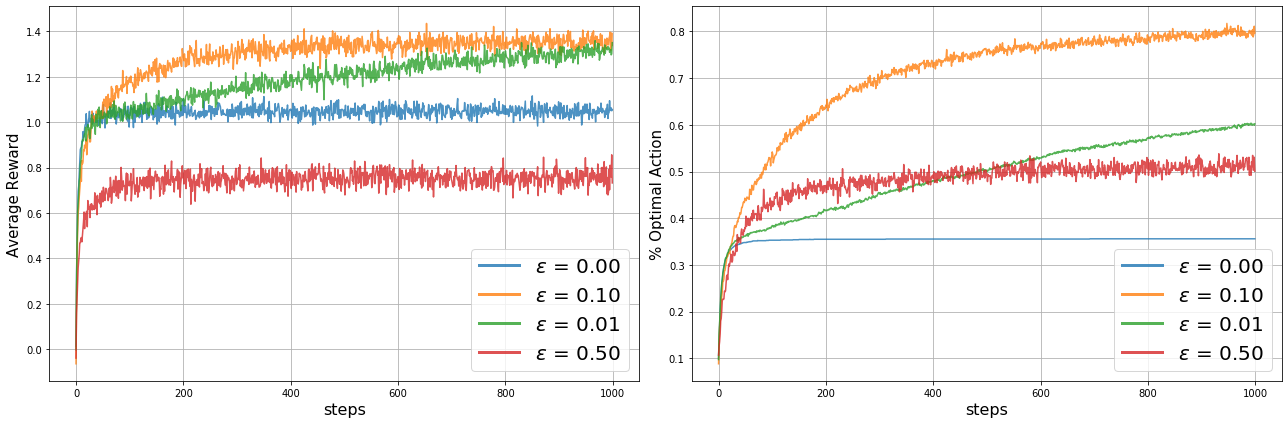

In [57]:
plot_bandits()

# Part 1: Tabular Q-Learning
## Reinforcement Learning

* In reinforcement learning the goal is to find a policy $\pi$ that obtains the biggest reward (or lowest cost) from a determined environment $\rightarrow$ **Optimal control problem**

    * The reward is, in general, a scalar function that changes given a state $s_t$ ($x_t$) and an action $a_t$ ($u_t$) and comprises that what wants to be optimized by the policy

Explain the Q function equation in the blackboard


## The Q-function
Expresses how well it is to act with an action $a$ given that the system is in state $s$. The "wellness" or "quality" is expressed in terms of the expected total reward to be received by acting with a policy $\pi$.

$$Q_{\pi}(s, a) = E_{\pi}\left[\sum_{k=0}^{\infty}\gamma^kr\left(s_{t+k}, a_{t+k}\right)\ \bigg|\ s_t = s, a_t = a\right]$$

* It follows a **Bellman expectation equation**:
    $$\tiny{Q_{\pi}(s,a)= \sum_{s_{t+1}, r(s_t,a_t)}\color{blue}{P\left(s_{t+1}, r(s_t, a_t)| s_t=s, a_t=a\right)}\left[\color{red}{r(s_t,a_t)}+\gamma\color{DarkOrchid}{\sum_{a_{t+1}}\pi(a_{t+1}|s_{t+1})Q_{\pi}(s_{t+1},a_{t+1})}\right]}$$
    <p>
        <center>        <img src="./imgs/qbackup.png" style="width: 280px;"/><em><small>Taken from Sutton, R. S., & Barto, A. G. (1998). Introduction to reinforcement learning<br>(Vol. 135). Cambridge: MIT press.</small></em></center>
    </p>

* And in optimality, $Q_{*}(s,a)\equiv max_\pi Q_{\pi}(s,a)\ \forall s,a$, the **Bellman optimality equation**

$$\small{Q_{*}(s,a)= \sum_{s_{t+1}, r(s_t,a_t)}{P\left(s_{t+1}, r(s_t, a_t)| s_t=s, a_t=a\right)}\left[r(s_t,a_t)+\gamma\ max_{a_{t+1}} Q_{*}(s_{t+1},a_{t+1})\right]}$$

Explain that the code is in python files inside the notebook folder in the jupyter session/ repository.
We are importing the code from there.

### A gridworld environment

In [70]:
import numpy as np                                      # numpy is for math operations.
import matplotlib.pyplot as plt                         # matplotlib.pyplot is to make plots.
from envs.environments import grid_world                # The grid_world environment.
from agents.Qlearning import tabular_Qlearning          # The RL agent (tabular Q-learning).
from utilities import plot_policies, plot_trayectory    # Pre-made functions to plot policies and trayectories.
from utilities import print_actions_taken               # Pre-made function to print a log with the actions taken.
import time                                             # To pause each step for some time

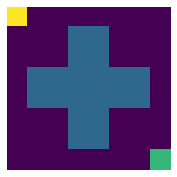

In [68]:
%matplotlib inline

env = grid_world()                  # Creates an environment instance called "env".
env_map = env.get_map()             # Generates an image with the map of the environment.

plt.figure(figsize=(3,3));          # These 3 are matplotplib functions that display the map of the environment.
plt.imshow(env_map);                #
plt.axis('off');                    #

The agent can execute 4 actions: 
* 0-UP
* 1-RIGHT
* 2-DOWN 
* 3-LEFT

* The state representation of this environment is the number of the cell where the agent is (i.e 0,1,2...63).
* **Important functions to interact with the environment...**

### env.step(): 
* **Input:** action. 
* **Output:** next state, reward and done (boolean flag to indicate terminal state). 
* **Function:** move the agent one cell in the direction given by the action (i.e. 0-UP, 1-RIGHT, 2-DOWN, 3-LEFT)

### env.reset():
* **Input:** a boolean flag to start at random positions (optional).
* **Output:** state. 
* **Function:** resets the environment.

### env.render():
* **Input:** none. 
* **Output:** the map of the environemt. 
* **Function:** renders the map of the environment.

As an example, lets run the environment for 20 steps taking random actions.

<IPython.core.display.Javascript object>


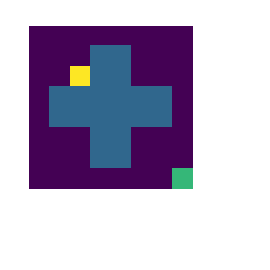

Step: 1    Action taken: LEFT
Step: 2    Action taken: UP
Step: 3    Action taken: LEFT
Step: 4    Action taken: LEFT
Step: 5    Action taken: RIGHT
Step: 6    Action taken: UP
Step: 7    Action taken: DOWN
Step: 8    Action taken: RIGHT
Step: 9    Action taken: UP
Step: 10    Action taken: DOWN
Step: 11    Action taken: DOWN
Step: 12    Action taken: RIGHT
Step: 13    Action taken: UP
Step: 14    Action taken: UP
Step: 15    Action taken: RIGHT
Step: 16    Action taken: UP
Step: 17    Action taken: LEFT
Step: 18    Action taken: DOWN
Step: 19    Action taken: DOWN
Step: 20    Action taken: DOWN


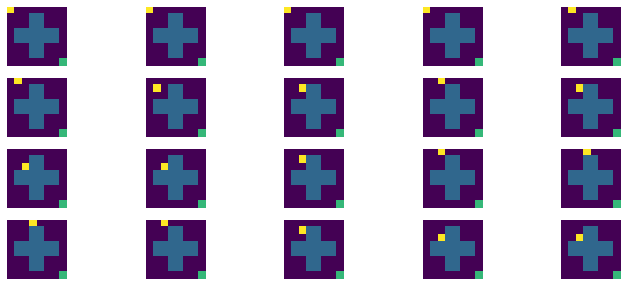

In [72]:
%matplotlib notebook

trayectory = []                     # Empty python list to save trayectory.
actions = []                        # Empty python list to save actions taken.

env = grid_world()                  # Creates an environment instance called "env".
env.reset()                         # Resets the environment.
for i in range(20):
    action = np.random.randint(0,4) # Generates a random int between 0 and 3 (4-1).
    
    env.step(action)                # Takes the action (moves the agent). 
    env_map = env.render()          # Renders the current map of the environment.
    
    trayectory.append(env_map)      # Adds the current map to the trayectory list.
    actions.append(action)          # Adds the taken action to the list.
    time.sleep(0.25)
    
%matplotlib inline

print_actions_taken(actions)
plot_trayectory(trayectory,size=(12,5))

## How to train the agent?

As we mentioned before, the agent (yellow) is going to be trained to acheieve the goal cell (green). To train it we are going to use the tabular version of the Q-learning algorithm. Let's try **Q-learning...**

#### Tabular Q-learning
<img src="./imgs/Qlearning_highlight.png">

**In our especific example with the grid_world environment:**
* $S$ is the set of cells of the grid_world enviroment. In our example $|S|=64$ because the grid_world has dimensions of $8\times8$
* $A$ is the set (0,1,2,3) of actions that the agent can execute (moving up, left, down or right).

* $P$ is the transition function from one cell to another given an action. **In our case this is a deterministic function of the environment and is unknown to the agent.**
    * Because it is deterministic the Bellman optimality equation is then reduced to
    
    $$\large Q_{*}(s,a)= r(s_t,a_t)+\gamma\ max_{a_{t+1}} Q_{*}(s_{t+1},a_{t+1})$$
    
    * Thus, the update is not just a sample to approximate the expectation.
     

* $r$ is a scalar function that has to reinforce the desired behavior of the agent. We are going to define this function later.

## The agent class
The agent class initializes a Q-table with $|S|$ rows and $|A|$ columns and all entries in $0$ and has the following methods already implemented:

* **greedy():** takes an state as input and returns an action being greedy with the current Q-values.
* **epsilon_greedy():** takes an state as input and returns a random action with epsilon probability or a greedy action with (1-epsilon) probability.
* **epsilon_decay():** exponentially decays the exploration parameter epsilon (i.e. epsilon = decay$*$epsilon with decay<1) **Why is this important?**

In [76]:
def run_Qlearning(env,agent,max_episodes,max_steps,exp_decay,start=False,seed=1234):
    np.random.seed(seed)                                           # Fixed random seed for reproducibility.
    agent.reset()                                                  # Initializes agent. Creates Q-table with zeros.
    policies = []                                                  # Creates an empty python list to save the policies.
    
    for episode in range(max_episodes+1):                          # Iterates over the number of episodes.
        state = env.reset(start)                                   # Resets the environment.
        done = False                                               # The done flag starts as False.
        step = 1                                                   # Step counter starts at 1.
        policies.append(agent.get_policy())                        # Adds current policy to the policies list.
        
        while (not done and step <= max_steps):                    # While loop for current episode.
            action = agent.epsilon_greedy(state)                   # Agent selects an action with epsilon-greedy policy.
            next_state,reward,done = env.step(action)              # Agent takes the selected action.
            agent.train(state,action,next_state,reward,done)       # Agent trains (updates Q-table entry).
            
            state = next_state                                     # Updates the current state.
            step += 1                                              # Increments the step counter in 1.
            
        agent.epsilon_decay(rate=exp_decay,min=0.1)                # Reduces the exploration parameter epsilon.
        
        if(episode%(max_episodes/10)==0):                          # This prints some information of the training process
            print('Episode: ',episode,' Steps: ',step,
                  ' Exploration: ',np.round(agent._epsilon,2))
            
    return policies                                                # The function returns the policies list.

### Q-learning algorithm (main code)
To run the agent (Q-learning algorithm) on the environment we have declared a function


`def run_Qlearning(env, agent, max_episodes, max_steps, exp_decay, start=False,seed=1234)` 

That returns the `policy (control actions / action profile)` that maximizes the `Q-function` after having trained the agent.

## Implementing the agent.train() function


This function performs the update:
\begin{equation}
    Q(s_t,a_t) = Q(s_t,a_t) + \alpha\bigg[r_{t+1} + \gamma\max_{\hat{a}}Q(s_{t+1},\hat{a}) - Q(s_t,a_t) \bigg]  
\end{equation}

To implement only this function we are going to create an instance of the tabular_Qlearning class and override the train method.

In [77]:
class our_Qlearning(tabular_Qlearning):          # This is a subclass of tabular_Qlearning and is called: our_Qlearning.
    
    def train(self,state,action,next_state,reward,done):  # Takes as input: state, action, next_state, reward, and done.
               
        if (not done):                                    # If the next_state is not a terminal state.
            maxQ = np.amax(self.Qtable[next_state,:])     # Maximization over actions.
            BE = reward + self._gamma*maxQ- self.Qtable[state,action] # Bellman error.
        else:
            BE = reward - self.Qtable[state,action]       # Bellman error.
        self.Qtable[state,action] += self._alpha*BE       # Table update (alpha denotes the learning rate).
        return 0.5*np.square(BE)                          # Returns half of the squared Bellman error. 

## Defining the reward function

As we mentioned before, the reward function of the environment is a scalar function that has to reinforce the desired behavior of the agent. In our case we want the agent to achieve the goal cell. To do so we are going to define two different reward functions:

#### Reward 1
\begin{equation}
    R(s) = 
        \begin{cases}
        +1, \text{    if the agent's cell is the goal cell.}\\
        0, \text{    otherwise.}
        \end{cases} 
\end{equation}

#### Reward 2
\begin{equation}
    R(s) = 
        \begin{cases}
        +1, \text{    if the agent's cell is the goal cell.}\\
        -1, \text{    otherwise.}
        \end{cases} 
\end{equation}

In [82]:
class grid_world_v1(grid_world):        # The first subclass is called: grid_world_v1.

    def reward(self):
        agent, target = self.observe()  # This function belongs to the grid_world class.
        if agent==target:
            return 1.0
        else:
            return 0.0
    
class grid_world_v2(grid_world):        # The second subclass is called: grid_world_v2.       
    
    def reward(self):
        agent, target = self.observe()  # This function belongs to the grid_world class.
        if agent==target:
            return 1.0
        else:
            return -1.0

# Lets run some experiments!

In order to explore the Q-learning algorithm lets run some experiments. For each experiment, set the parameters of the **Train the agent** cell as shown and then try to answer the question. After training, run the **Test the agent** cell to see the behavior learned by the agent.

#### Experiment 1
* env = grid_world_v1()
* max_eps = 100
* max_steps = 100
* exp_decay = 0.99
* random = False

**Why does the agent fail to solve the environment?**

#### Experiment 2
* env = grid_world_v1()
* max_eps = 100
* max_steps = 200
* exp_decay = 0.99
* random = False

**Can the agent solve the environment from every possible state?**

#### Experiment 3
* env = grid_world_v1()
* max_eps = 500
* max_steps = 200
* exp_decay = 0.99
* random = True

**Is the final policy optimal?**

#### Experiment 4
* env = grid_world_v1()
* max_eps = 500
* max_steps = 200
* exp_decay = 0.90
* random = True

**Why does the agent fail to solve the environment now?**

#### Experiment 5
* env = grid_world_v2()
* max_eps = 500
* max_steps = 200
* exp_decay = 0.99
* random = True

**Is the final policy better than the one of experiment 3? Is it optimal?**



### Train the agent

Episode:  0  Steps:  101  Exploration:  0.99
Episode:  10  Steps:  101  Exploration:  0.9
Episode:  20  Steps:  101  Exploration:  0.81
Episode:  30  Steps:  101  Exploration:  0.73
Episode:  40  Steps:  101  Exploration:  0.66
Episode:  50  Steps:  101  Exploration:  0.6
Episode:  60  Steps:  101  Exploration:  0.54
Episode:  70  Steps:  101  Exploration:  0.49
Episode:  80  Steps:  101  Exploration:  0.44
Episode:  90  Steps:  101  Exploration:  0.4
Episode:  100  Steps:  101  Exploration:  0.36
______________________
UP, RIGHT, DOWN, LEFT


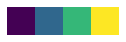

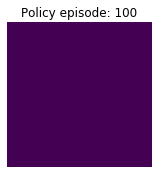

In [100]:
env = grid_world_v1()                                              # Environment instance with the first reward function.
max_eps = 100                                                      # Max number of episodes to train
max_steps = 100                                                    # Max number of steps per episode during training
exp_decay = 0.99                                                   # Exploration parameter decay
random = False                                                    # Flag to use random initial state

agent = our_Qlearning(num_states=64, num_actions=4, lr=0.5)          # Agent as instance of our_Qlearning class.

policies = run_Qlearning(env, agent, max_eps, max_steps, exp_decay, random) # Run the Qlearning algorithm

plot_policies(policies, (1, 1))                         # Plot some policies (add (1,1) arg to plot only the last one)

### Test the agent 
#### (runs the learned policy for 5 episodes of 20 steps max)

<IPython.core.display.Javascript object>


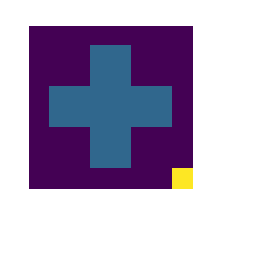

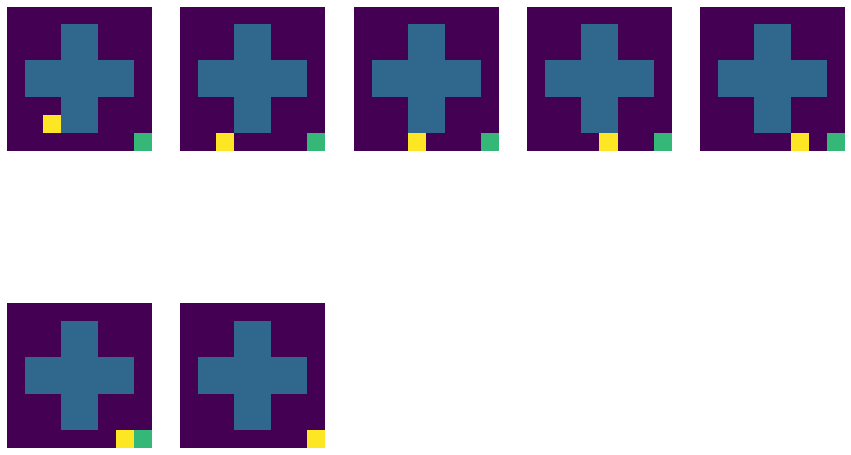

In [89]:
%matplotlib notebook

env = grid_world()                             # Creates a new instance of the environment (required for rendering).

for episode in range(5):                       # Loop over some episodes.
    state = env.reset(random)                  # Reset the environment.
    done = False                               # done flag starts as false.
    step = 1                                   # step counter starts in 1.
    
    trayectory = [env.get_map()]               # Python list to save trayectory of episode.
    while (not done and step < 20):            # Looping until terminal or during max steps.
        action = agent.greedy(state)           # Select action based on greedy policy.
        state,_,done = env.step(action)        # Take selected action.
        env_map = env.render()                 # Render the current map of the environment.
        step += 1                              # Increase step counter by one.
        
        trayectory.append(env_map)
        actions.append(action)

%matplotlib inline

plot_trayectory(trayectory)

# Concluding remarks

* Tabular Q-learning is able to learn the optimal policy if enough training iterations are provided.
* Tabular Q-learning is no able to generalize information. Therefore, in order to solve the environment from every possible state, all states must be visited several times.
* Due to the lack of generalization, tabular Q-learning is not suitable for continuous or very big state spaces.
